In [2]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

# Hierarchichal training

In our case we can make problem gradually more difficult to solve, while keeping the the `A` matrix in exactly the same shape. This should allow us to use the same `ResGCN`

- First way is to increase the scale of the filter, as the bigger scacle the worse is the conditioning of the matrix. 
- Second is increasing the order of the filer `n`, which makes much more difficult to solve the problem
---

To start we have to generate sythetic problem of given size

In [3]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

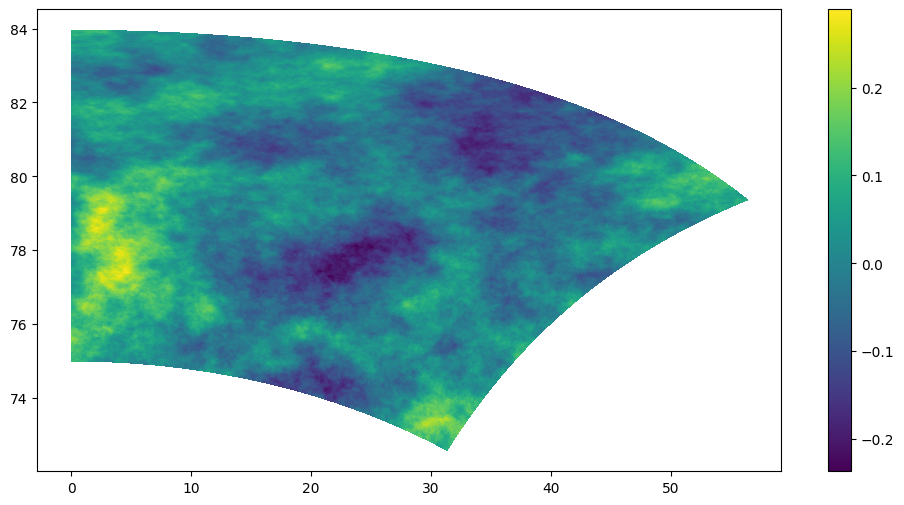

In [4]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

Now lets define model parameters 

In [5]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

Now we need to create scales that we want to use

In [6]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [7]:
tt.shape

(251001,)

Now we define the matricies for model to learn preconditioning

In [8]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

/tmp/ipykernel_4167379/641305269.py:9: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)


Now model can be initialized for the first phase of training

In [9]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

As a test we will solve the problem without preconditioner 

In [10]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=19999, progress_bar=True)
    print("Iteration " + str(iters))
    iterations[i] = iters

Solve:   1%|          | 139/19999 [00:00<01:19, 248.58it/s]


Iteration 139


Solve:   2%|▏         | 350/19999 [00:00<00:36, 536.72it/s]


Iteration 350


Solve:   5%|▍         | 922/19999 [00:01<00:35, 540.84it/s]


Iteration 922


Solve:  13%|█▎        | 2545/19999 [00:04<00:31, 546.73it/s]


Iteration 2545


Solve:  36%|███▌      | 7188/19999 [00:13<00:23, 536.16it/s]


Iteration 7188


Solve:  99%|█████████▉| 19861/19999 [00:36<00:00, 544.84it/s]


Iteration 19861


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.16it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.52it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.63it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 553.98it/s]

Iteration 19999


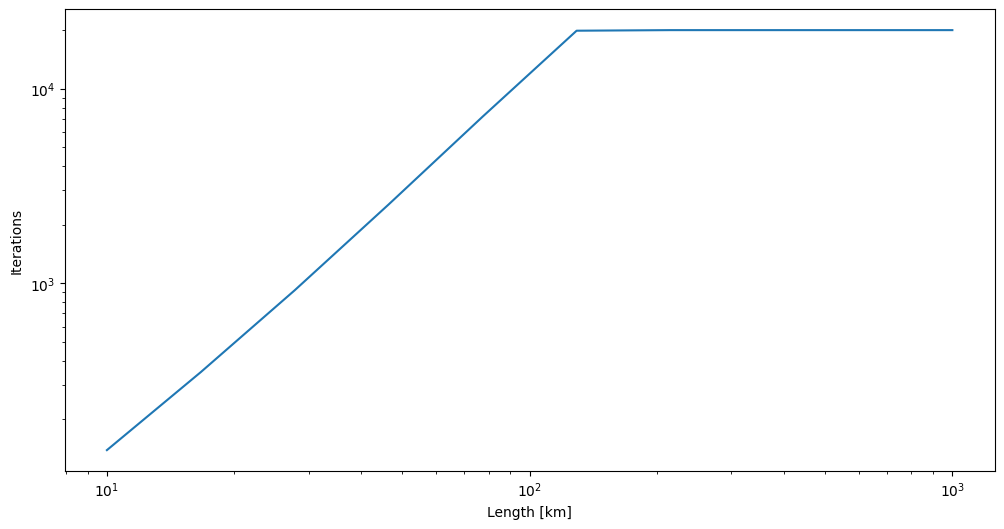

In [11]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

In [11]:
### Approach to truncate at max_iters and recover actual plot ###

In [12]:
#iterations = []
#valid_lengths = []

#max_iters = 19999
#rtol = 1e-6

#for i in range(len(As)):
    #ttw = data - As[i] @ data
    #x, iters, abs_res, rel_res, _ = solver.solve(
    #    A=As[i], b=ttw, rtol=rtol, max_iters=max_iters, progress_bar=False
    #)

    #final_residual = rel_res[-1]
    #print(f"Length {lengths[i]}: {iters} steps, final relres = {final_residual:.2e}")

    # Stop adding once solver doesn't converge
#    if final_residual > rtol or iters == max_iters:
 #       print(f"Stopped at index {i}: did not converge.")
  #      break

   # iterations.append(iters)
    #valid_lengths.append(lengths[i])

#plt.figure(figsize=(6, 4))
#plt.plot(truncated_lengths, iterations, marker='o')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel("Length [km]", fontsize=10)
#plt.ylabel("Iterations", fontsize=10)
#plt.title("Solver Convergence vs. Problem Scale", fontsize=11)
#plt.grid(True, which='both', linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()


NameError: name 'lengths' is not defined

Now we can only solver problems up to 200 km. Now we run first phase of training 

In [12]:
import time 

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')

/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Done. Training time: 111.92021799087524 seconds
Loss: inital = 0.10156530044394453, final = 0.010904818164122842, best = 0.010298008975919891, epoch = 978


With preconditioner for the sample problem

In [13]:
iterations_pre = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    print("Iteration " + str(iters))
    iterations_pre[i] = iters

Solve:   0%|          | 29/20000 [00:00<06:20, 52.50it/s]


Iteration 29


Solve:   0%|          | 52/20000 [00:00<06:10, 53.91it/s]


Iteration 52


Solve:   1%|          | 104/20000 [00:01<06:07, 54.12it/s]


Iteration 104


Solve:   1%|▏         | 252/20000 [00:04<06:04, 54.13it/s]


Iteration 252


Solve:   4%|▎         | 721/20000 [00:13<05:55, 54.28it/s]


Iteration 721


Solve:  12%|█▏        | 2311/20000 [00:42<05:26, 54.24it/s]


Iteration 2311


Solve:  40%|███▉      | 7942/20000 [02:26<03:42, 54.27it/s]


Iteration 7942


Solve: 100%|██████████| 20000/20000 [06:09<00:00, 54.13it/s]


Iteration 20000


Solve: 100%|██████████| 20000/20000 [06:08<00:00, 54.32it/s]


Iteration 20000


Solve: 100%|██████████| 20000/20000 [06:08<00:00, 54.27it/s]

Iteration 20000


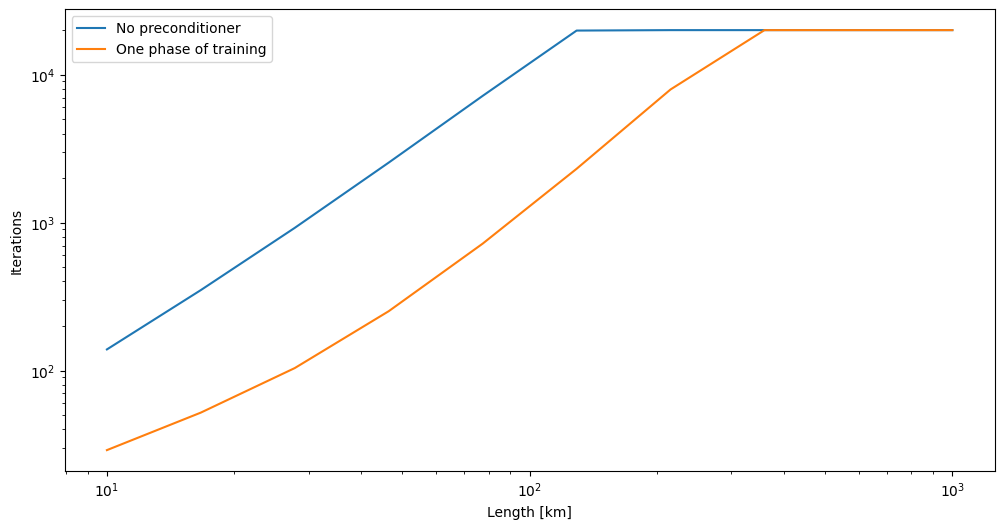

In [14]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
    

Not great, not terrible. Now let's try training for larger scales, but we reduce amount of time we spend on each case

In [15]:
! rm ./*.pt

/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


I reduced number of epochs so the total training budget is the same as for 1 phase

In [16]:
net = ResGCN(As[0], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

for A in As: 
    M.A = A
    hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs // 10, optimizer, scheduler, num_workers=4, 
    checkpoint_prefix_with_path="./tmp_", progress_bar=False)
    M.net.load_state_dict(torch.load(f"./tmp_epoch_{best_epoch}.pt", map_location=device, weights_only=True))
    print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
    

Loss: inital = 0.1041199420834413, final = 0.018178377472835645, best = 0.017342002324280868, epoch = 96
Loss: inital = 0.01776914916837367, final = 0.016265433525603157, best = 0.015004038348268583, epoch = 84
Loss: inital = 0.015380541125286898, final = 0.015037975926857752, best = 0.013407786525581044, epoch = 80
Loss: inital = 0.013638008828653505, final = 0.015010876393634883, best = 0.013301430192328014, epoch = 79
Loss: inital = 0.01357336704353304, final = 0.013561973576927955, best = 0.012632784785800346, epoch = 93
Loss: inital = 0.012688562435618254, final = 0.013049256543024202, best = 0.012008899979802801, epoch = 43
Loss: inital = 0.012552258000426812, final = 0.01301440495048267, best = 0.011794609317038221, epoch = 94
Loss: inital = 0.01237252453815988, final = 0.013225021551490298, best = 0.01147923875404073, epoch = 79
Loss: inital = 0.012398281236939602, final = 0.011782765252280461, best = 0.011240980438891207, epoch = 13
Loss: inital = 0.011344723484059927, final =

In [17]:
iterations_post = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=20000, progress_bar=True, M=M)
    print("Iteration " + str(iters))
    iterations_post[i] = iters

Iteration 32
Iteration 58
Iteration 111
Iteration 261
Iteration 748
Iteration 2393
Iteration 7793
Iteration 20000
Iteration 20000
Iteration 20000


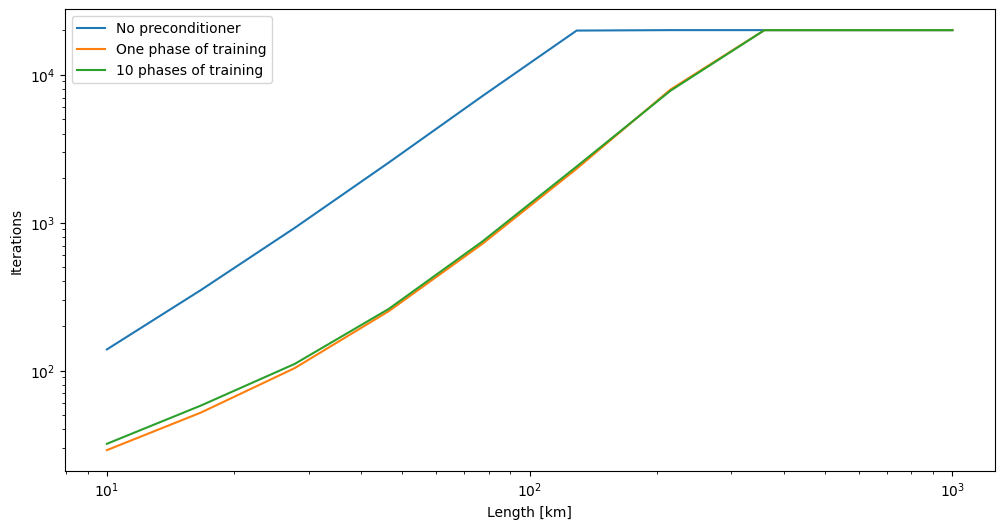

In [18]:
plt.plot(np.logspace(1, 3, 10), iterations, label="No preconditioner")
plt.plot(np.logspace(1, 3, 10), iterations_pre, label="One phase of training")
plt.plot(np.logspace(1, 3, 10), iterations_post, label="10 phases of training")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
### Condition Number Plot ###

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

condition_numbers = []
epochs_tracked = []

dataset = StreamingDataset(A, batch_size=batch_size,
                           training_data=training_data, m=m)
loader = iter(torch.utils.data.DataLoader(dataset, num_workers=0, batch_size=None))

log_intervals = 20  
interval = 3000 // log_intervals

print("Tracking condition number during training evaluation...")

for i in range(log_intervals + 1):
    epoch = i * interval
    x_or_b = next(loader)

    if training_data != 'no_x':
        x = x_or_b.to(device)
        b = A @ x
        b, x = b.to(net.dtype), x.to(net.dtype)
    else:
        b = x_or_b.to(device).to(net.dtype)

    with torch.no_grad():
        x_out = net(b)

    try:
        ratio = torch.linalg.lstsq(x_out.double(), b.double()).solution
        cond = np.linalg.cond(ratio.cpu().numpy())
        condition_numbers.append(cond)
        epochs_tracked.append(epoch)
        print(f"Epoch {epoch:4d}: Condition number = {cond:.2e}")
    except Exception as e:
        print(f"Failed at epoch {epoch}: {e}")
        condition_numbers.append(np.nan)
        epochs_tracked.append(epoch)

plt.figure(figsize=(8, 5))
plt.plot(epochs_tracked, condition_numbers, marker='o')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Estimated Condition Number")
plt.title("Condition Number Evolution During Training")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()
